# Peak detection

Based on this SO answer https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/22640362#22640362

code for peak detection taken from here: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/56451135#56451135

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.preprocessing import quantile_transform

%matplotlib inline

In [2]:
full = pd.read_csv('data/CA1_6_1_clean.csv')

In [3]:
full.head()

time        0N        1N        2N        3N        4N        5N        6N  \
0     6 -0.004105 -0.002713  0.002400 -0.002804  0.013982  0.004319 -0.003357   
1     7 -0.004401 -0.004511  0.001104 -0.002070  0.012163  0.003325 -0.001147   
2     8 -0.003786 -0.005022  0.001733 -0.000330  0.013810  0.003872 -0.003216   
3     9 -0.005539 -0.005892 -0.000947 -0.003324  0.012719  0.001616 -0.002414   
4    10 -0.004962 -0.007518  0.002856 -0.002459  0.012671  0.004508 -0.002190   

         7N        8N  ...      583N      584N      585N      586N      587N  \
0 -0.001776 -0.002052  ...  0.000585  0.005413  0.009618  0.004061  0.004675   
1 -0.003996 -0.003540  ... -0.000170  0.007227  0.008670  0.006076  0.006172   
2 -0.002088 -0.003463  ... -0.001343  0.007866  0.008944  0.009129  0.003572   
3 -0.003358 -0.002223  ...  0.000458  0.006610  0.009690  0.007303  0.006286   
4 -0.003734 -0.000925  ... -0.000420  0.006400  0.007676  0.003326  0.006363   

       588N      589N          x         y  segment  
0  0.001152 -0.000333 -15.463624  2.932973      4.0  
1 -0.001081 -0.002290 -16.404171  3.408579      4.0  
2  0.000140 -0.003384 -17.335852  3.910841      4.0  
3 -0.001653 -0.002121 -18.261171  4.434826      4.0  
4 -0.001662 -0.003236 -19.161957  5.008783      4.0  

[5 rows x 594 columns]

# Why peak detection?

lets look at time-series of cells

In [49]:
def get_angle(coordinates, cx = 0, cy = 0):
    return np.angle((coordinates['x'] - cx) + 1j * (coordinates['y'] - cy))

In [50]:
x_max, y_max = full[['x', 'y']].max()
x_min, y_min = full[['x', 'y']].min()

radius_x = (x_max - x_min) / 2
radius_y = (y_max - y_min) / 2
radius = (radius_x+radius_y)/2

cx1 = x_max - radius
cx2 = x_min + radius
cx = (cx1 + cx2) / 2
cy1 = y_max - radius
cy2 = y_min + radius
cy = (cy1 + cy2) / 2

The only problem is the 180 deg angle => See how the model performs

In [51]:
mi = full.copy()

In [52]:
mi['ang'] = get_angle(mi, cx, cy)


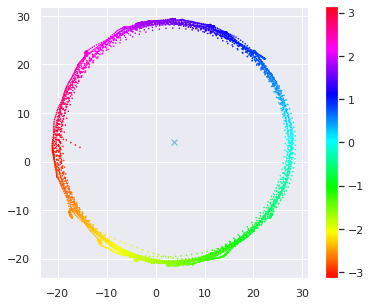

In [53]:
fig, ax = plt.subplots(figsize=(6, 5), ncols=1)
plt.scatter(mi['x'], mi['y'],
        c=mi['ang'],
        cmap='hsv',
        linewidth=0,
        s=2.5)
plt.plot(cx, cy, 'cx') 
plt.colorbar();

In [54]:
mi.drop(['time', 'segment', 'x', 'y'], axis=1, inplace=True)

In [55]:
N_NEURONS = 24

In [56]:
from sklearn.feature_selection import mutual_info_regression

In [57]:
mi_scores = mutual_info_regression(mi.drop(['ang'], axis=1), mi['ang'])

In [58]:
mi_scores_df = pd.DataFrame([mi_scores], columns=mi.drop(['ang'],axis=1).columns).T.rename(columns={0: 'mi_score'})

In [59]:
mi_scores_df = mi_scores_df.sort_values(by=['mi_score'], ascending=False)

In [60]:
best = mi_scores_df.iloc[:N_NEURONS]

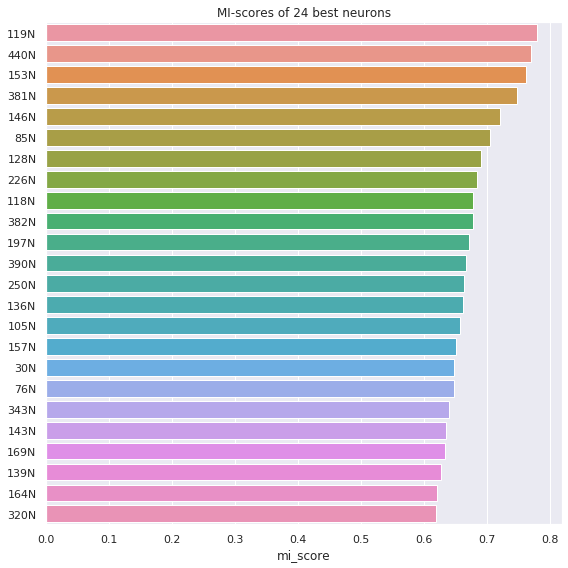

In [61]:
fig, ax = plt.subplots(figsize=(8, 8), ncols=1)

ax = sns.barplot(x=best['mi_score'], y=best.index, ax=ax);
ax.set_title("MI-scores of 24 best neurons");
fig.tight_layout();

In [62]:
worst = mi_scores_df.iloc[-N_NEURONS:].sort_values(by=['mi_score'], ascending=True)

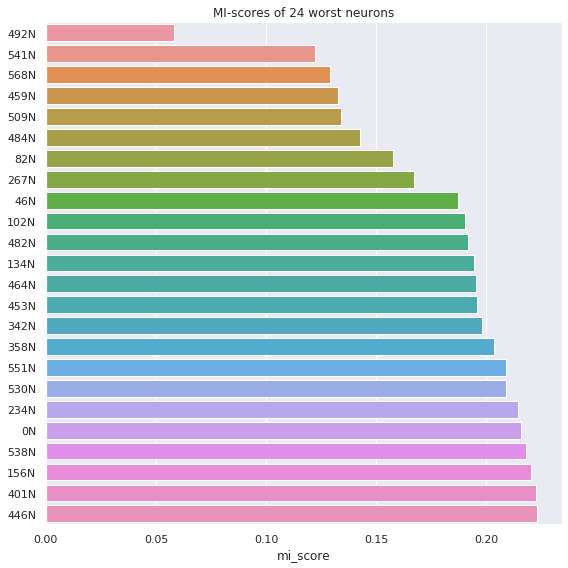

In [63]:
fig, ax = plt.subplots(figsize=(8, 8), ncols=1)

ax = sns.barplot(x=worst['mi_score'], y=worst.index, ax=ax);
ax.set_title("MI-scores of 24 worst neurons");
fig.tight_layout();

In [29]:
neurons = best.index[:24]

In [30]:
fine_cells = pd.read_csv('data/CA1_6_1_fine_cells.csv', index_col=0)
fine_cells.index.names = ['time']
fine_cells.index = (fine_cells.index * 20).astype(np.int32)
fine_cells.columns = fine_cells.columns.astype(str) + 'N'

fine_neurons = fine_cells.columns
mi_best_neurons = best[:24].index

fine_mi_intersect = set(fine_neurons) & set(mi_best_neurons)
print(f" Intersection with fine({len(fine_mi_intersect)}): {' '.join(fine_mi_intersect)}")

 Intersection with fine(4): 143N 153N 136N 128N


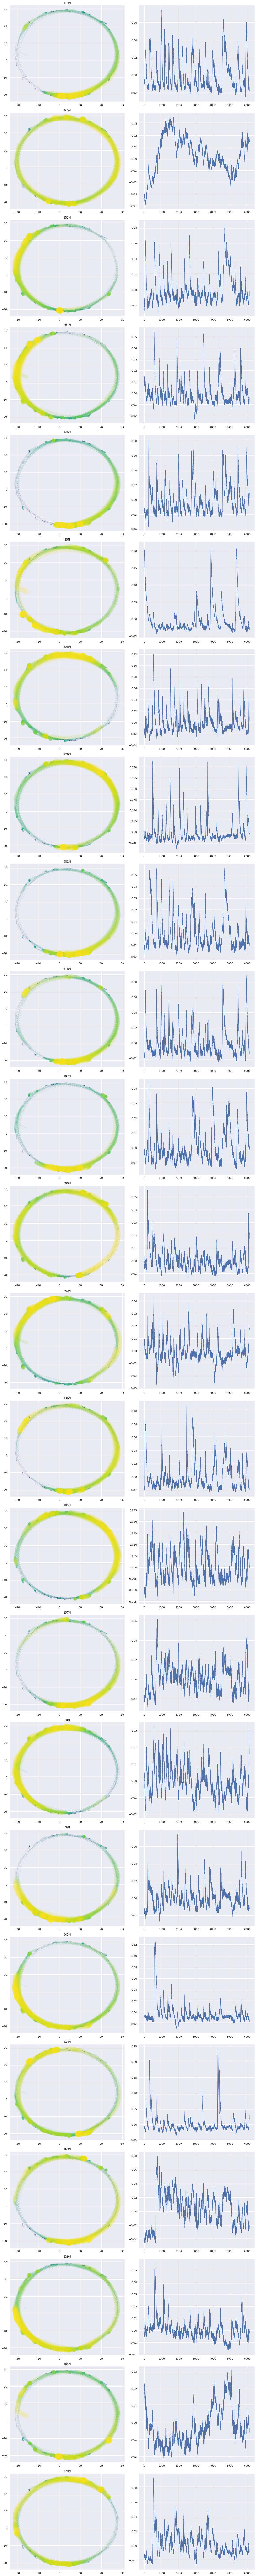

In [33]:
plt.figure(figsize=(15, 150))

N_NEURONS = len(neurons)
for i, n in enumerate(neurons):
    plt.subplot(N_NEURONS, 2, i * 2 + 1)
    plt.title(n)
    s = full.loc[:, ['x', 'y', n]].sort_values(n)
    s[n] = quantile_transform(s[n].values.reshape(-1, 1), copy=True)
    # heatmap
    plt.scatter(s['x'], s['y'],
                c=s[n],
                cmap='viridis',
                linewidth=0,
                s=np.exp(6.5*s[n]),
                alpha=0.1,
                edgecolors='none')
    
    plt.subplot(N_NEURONS, 2, i * 2 + 2)
    plt.plot(full[n])

plt.tight_layout();
plt.savefig('img/best_mi_time_series.png')

In [27]:
neurons = worst.index[:10]

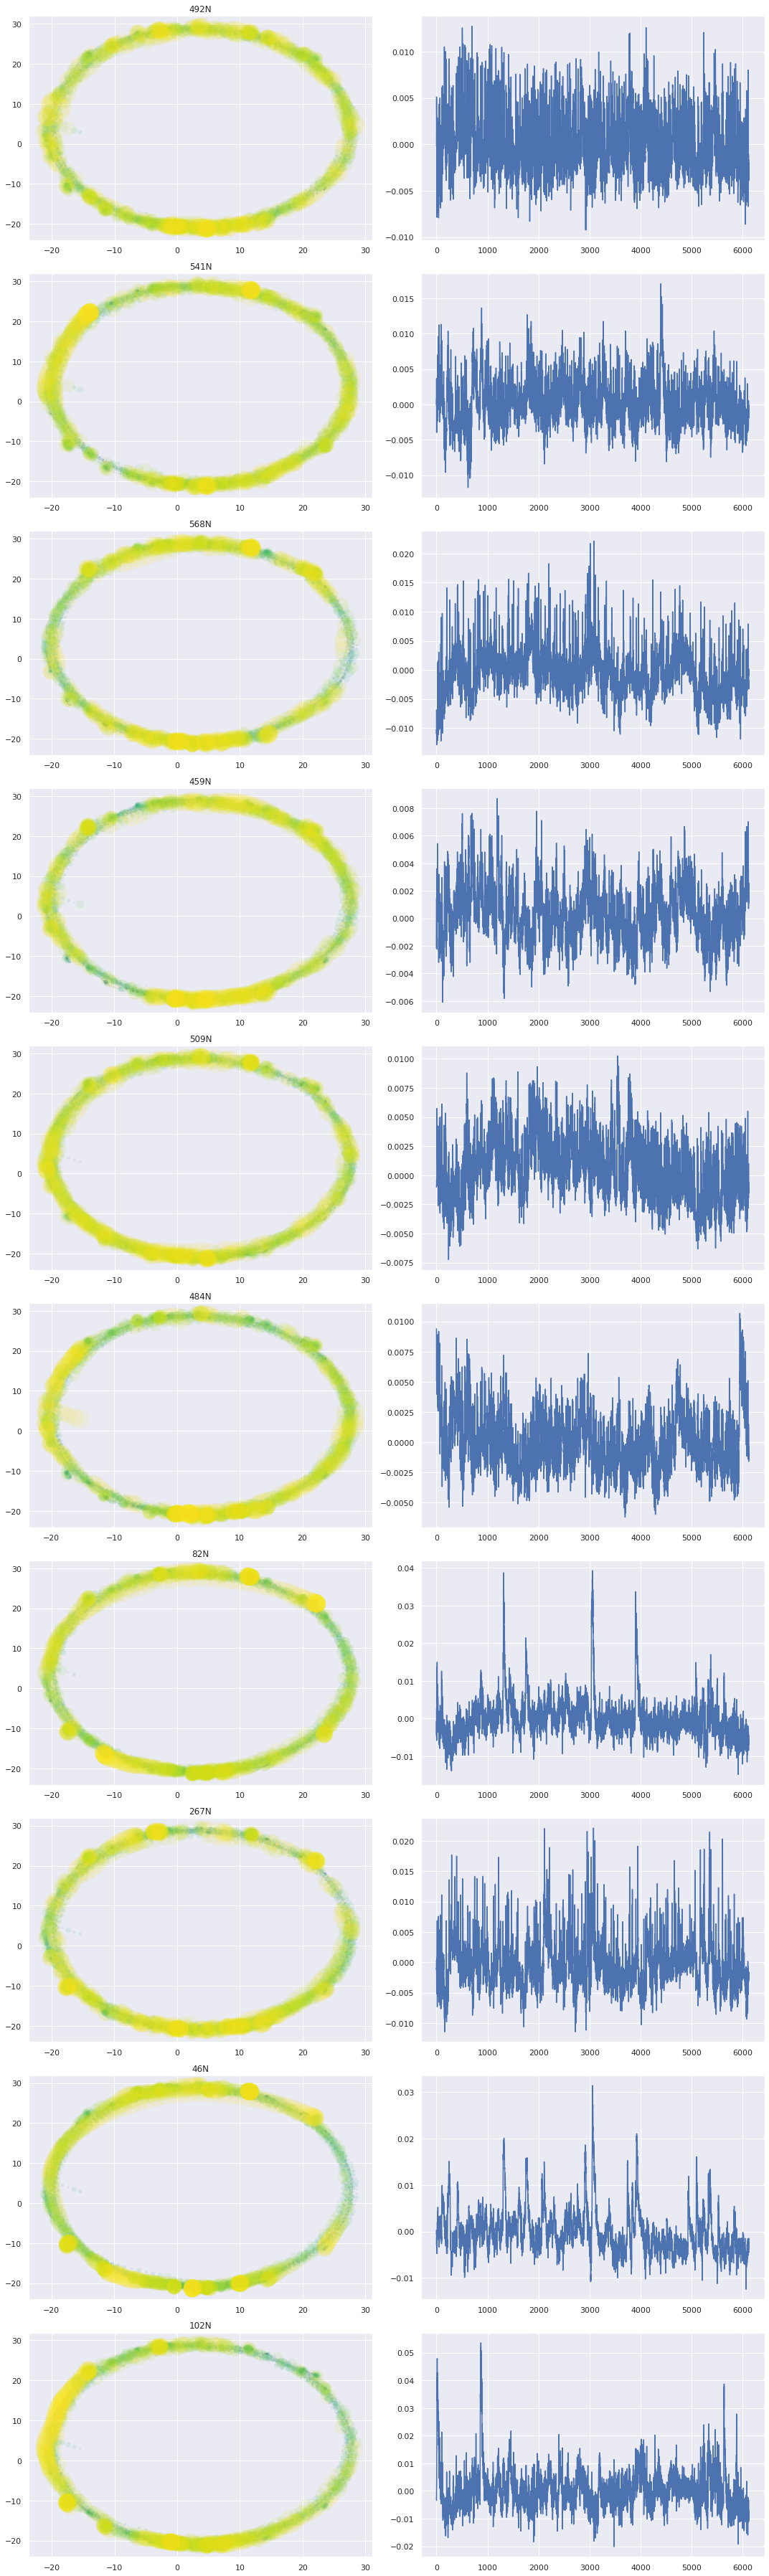

In [28]:
plt.figure(figsize=(15, 50))

N_NEURONS = len(neurons)
for i, n in enumerate(neurons):
    plt.subplot(N_NEURONS, 2, i * 2 + 1)
    plt.title(n)
    s = full.loc[:, ['x', 'y', n]].sort_values(n)
    s[n] = quantile_transform(s[n].values.reshape(-1, 1), copy=True)
    # heatmap
    plt.scatter(s['x'], s['y'],
                c=s[n],
                cmap='viridis',
                linewidth=0,
                s=np.exp(6.5*s[n]),
                alpha=0.1,
                edgecolors='none')
    
    plt.subplot(N_NEURONS, 2, i * 2 + 2)
    plt.plot(full[n])

plt.tight_layout();
plt.savefig('img/worst_mi_time_series.png')

## Conclusion

use peak detection for place cells.

cell with a relatively high number of peaks most likely is a place cell

# Actual peak detection

In [149]:
from scipy.signal import find_peaks

In [163]:
neurons = full.drop(['time', 'x', 'y', 'segment'],axis=1).columns

In [164]:
n_out = []

In [165]:
stat = full.describe()
for n in neurons:
    peaks = find_peaks(full[n], distance=100)[0]
    mean = stat[n].loc['mean']
    std = stat[n].loc['std']
    upper = mean + std * 3
    coord = []
    for p in peaks:
        r = full.iloc[p]
        if (r[n] > upper):
            coord.append((p, r[n]))
    n_out.append(len(coord))

In [166]:
n_out_s = pd.Series(n_out, index=neurons)

In [167]:
n_out_df = n_out_s.to_frame().rename({0:'peaks'}, axis=1)

In [168]:
out_df = pd.merge(mi_scores_df, n_out_df, how='inner', left_index=True, right_index=True)

In [169]:
out_df.head()

mi_score  peaks
119N  0.779040      3
440N  0.769507      0
153N  0.760777      6
381N  0.746551      6
146N  0.720219      5

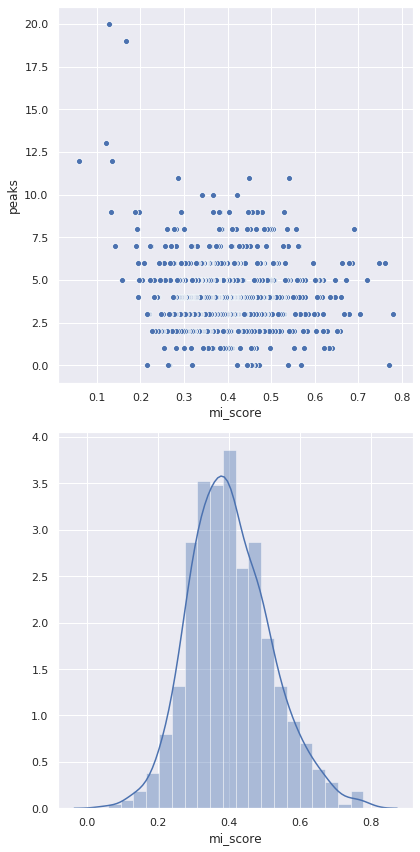

In [170]:
plt.figure(figsize=(6, 12))
ax = plt.subplot(2, 1, 1)
sns.scatterplot(x='mi_score', y='peaks', data=out_df, ax=ax)

ax = plt.subplot(2, 1, 2)
sns.distplot(out_df['mi_score'], ax=ax)

plt.tight_layout();
plt.savefig('img/out_scatter.png')

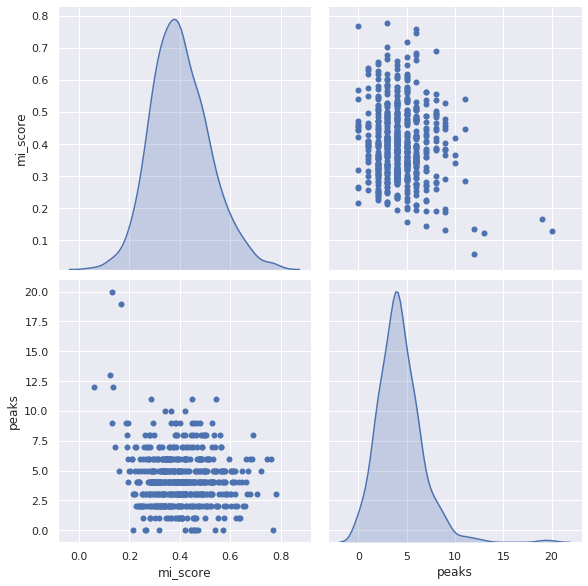

In [171]:
sns_plot = sns.pairplot(out_df, height=4, diag_kind="kde", plot_kws={"linewidth":0});
sns_plot.savefig("img/out_scatter.png")

Train lin reg to predict mi_score based on the number of peaks

In [19]:
neurons = n_out_s[:10].index

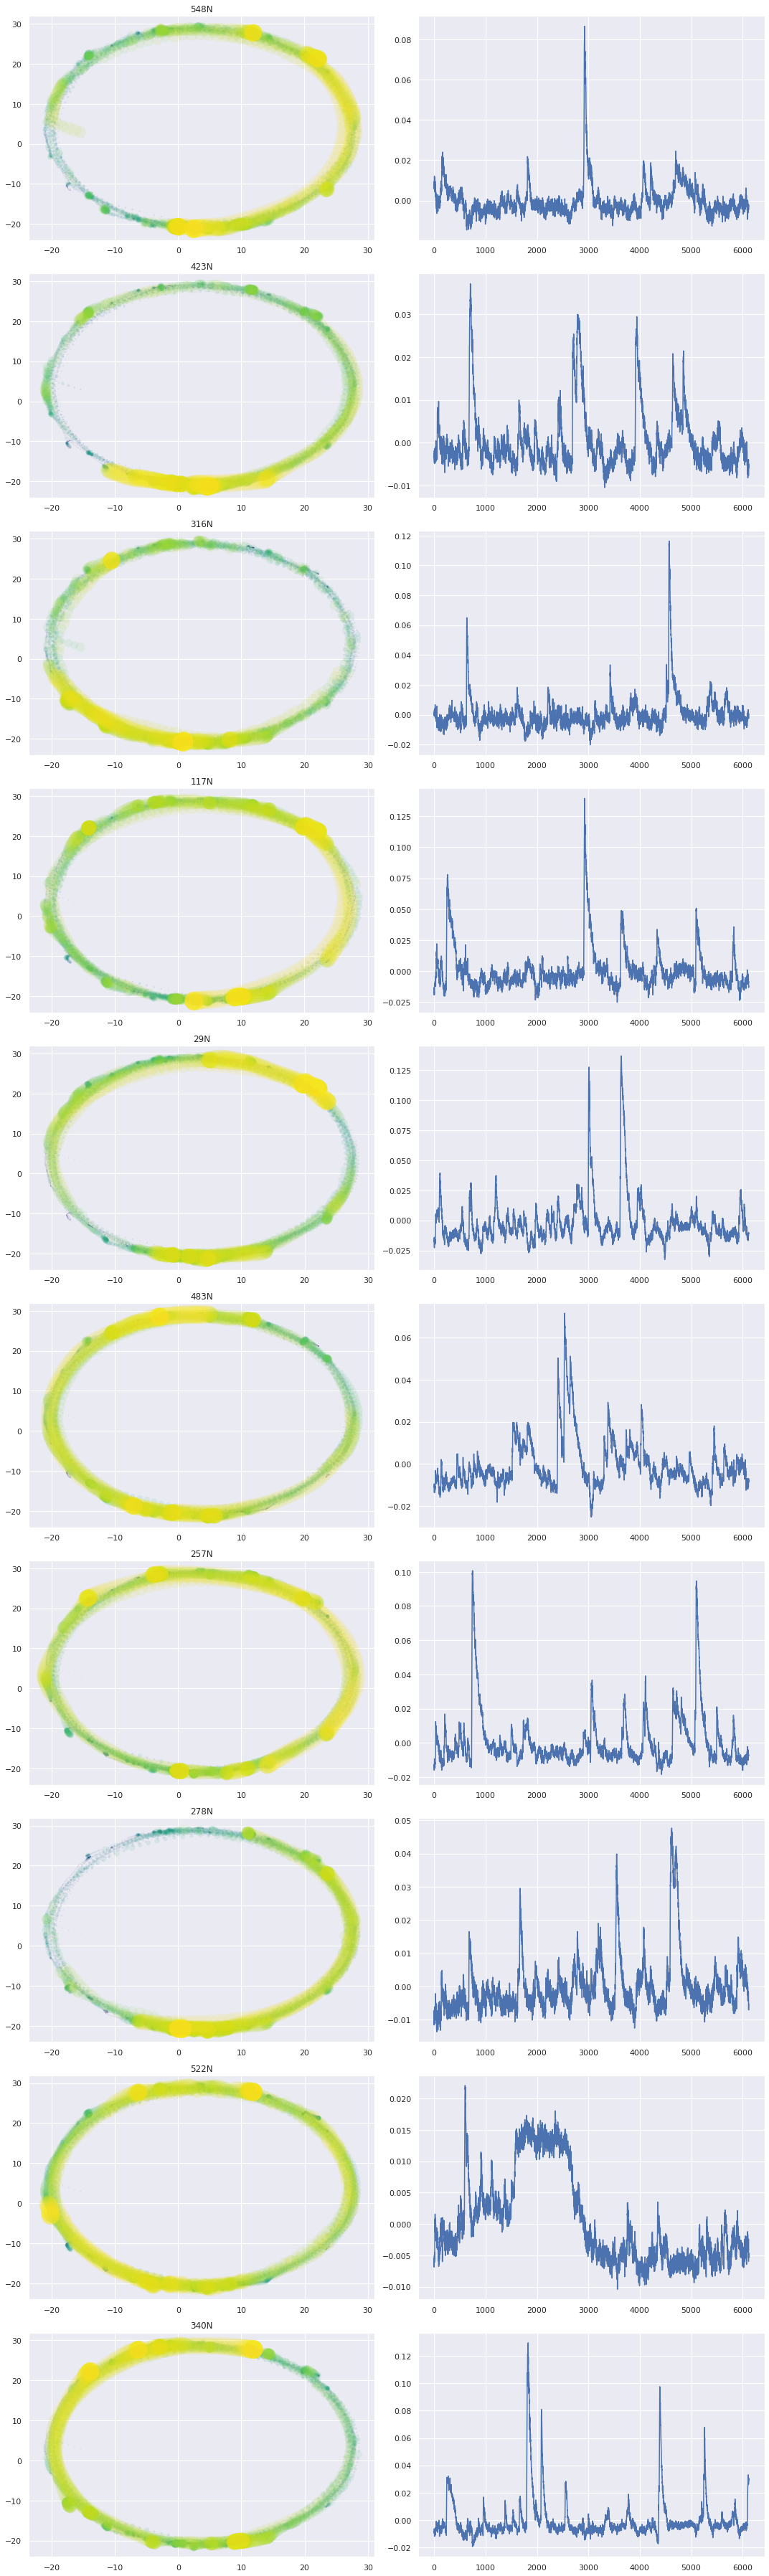

In [20]:
plt.figure(figsize=(15, 50))

N_NEURONS = len(neurons)
for i, n in enumerate(neurons):
    plt.subplot(N_NEURONS, 2, i * 2 + 1)
    plt.title(n)
    s = full.loc[:, ['x', 'y', n]].sort_values(n)
    s[n] = quantile_transform(s[n].values.reshape(-1, 1), copy=True)
    # heatmap
    plt.scatter(s['x'], s['y'],
                c=s[n],
                cmap='viridis',
                linewidth=0,
                s=np.exp(6.5*s[n]),
                alpha=0.1,
                edgecolors='none')
    
    plt.subplot(N_NEURONS, 2, i * 2 + 2)
    plt.plot(full[n])

plt.tight_layout();
plt.savefig('img/best_out_time_series.png')

# Method described in
https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1000205&type=printable

In [4]:
full = full.drop(['time', 'x', 'y', 'segment'], axis=1)

In [5]:
full_theta = full[:0]
for i in range(0, full.shape[0], 5):
    full_theta = full_theta.append(full[i:i+5].mean(), ignore_index=True)

In [6]:
stat = full_theta.describe()

In [7]:
neuron_activity = full[:0]
for n in full_theta.columns:
    neuron_activity[n] = full[n].apply(lambda x: x > stat[n]['mean'])


In [18]:
from dionysus import Filtration, homology_persistence, init_diagrams, Simplex
from collections import Counter
number_of_ap = 3
alpha=0.5

from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

filtration = Filtration()

sims = Counter()
for idx, row in neuron_activity.iterrows():
    vert = tuple(np.where(row)[0])
    sims[vert]+=1

complexes = []
for s, cnt in sims.items():
    if s == ():
        continue
    if cnt > number_of_ap:
        complexes.append(s)


all_simplexes = set()
for compl in complexes:
    for s in list(powerset(compl))[1:]:
        all_simplexes.add(s)

all_simplexes = sorted(list(all_simplexes), key=lambda x: len(x))
for sim in all_simplexes:
    filtration.append(Simplex(sim, alpha))



In [19]:
filtration

Filtration with 0 simplices

In [39]:
all_simplexes

[(0,)]

In [40]:
sims

Counter({(0,): 590})